In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf  
from keras.layers import LSTM, Dense,Dropout, Bidirectional
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.utils import plot_model
from keras.layers import LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error


C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

In [2]:
df=pd.read_csv('lstm_passenger.csv')
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
print(df.columns)

Index(['Month', 'Passengers'], dtype='object')


In [3]:
#filter=df['WasHired']==1
#df['StartDate']=pd.to_datetime(df['StartDate'])
#df=df.sort_values(by='StartDate',ascending=False)

df['Month']=pd.to_datetime(df['Month'])
df=df.sort_values(by='Month',ascending=False)

Text(0.5, 1.0, 'Passengers')

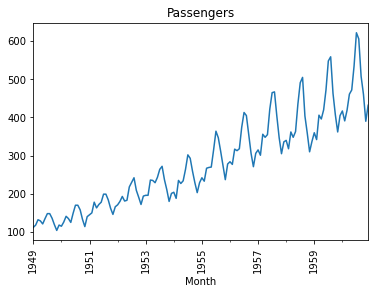

In [4]:
grouped=df.groupby('Month')
passengers=grouped['Passengers'].sum()
passengers.plot()
plt.xticks(rotation=90)
plt.title('Passengers')
#plt.plot(hired.index,'WasHired', data=hired)

Instructions for updating:
Colocations handled automatically by placer.


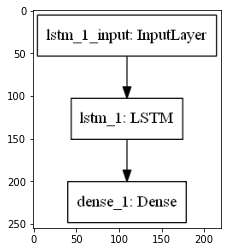

In [5]:
look_back = 3

# LSTM configuration 1
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

#n_future = 1
#n_past=30
#timeSteps=1
#features=1
#model = Sequential()

#model.add(Bidirectional(LSTM(units=30, return_sequences=True,input_shape=(timeSteps, features))))

#model.add(LSTM(units= features, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(units= features, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(units= features))
#model.add(Dropout(0.2))
#model.add(Dense(units = n_future, activation="relu"))
#model.compile(optimizer="adam", loss="mean_squared_error", metrics=["acc"])

plot_model(model, to_file='model.png')
img=plt.imread('model.png')
plt.imshow(img)
plt.show()

In [6]:
dataset=passengers


In [7]:
# normalize the dataset

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.array(dataset).reshape(-1,1))

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# normalize the dataset

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=0)


96 48
Instructions for updating:
Use tf.cast instead.


In [9]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

#pred_y = model.predict(testX)
#plt.figure(figsize=(10,3)) #fig size same as before
#ax = plt.gca() #you first need to get the axis handle
#ax.set_aspect(1.5) #sets the height to width ratio to 1.5. 
#ax.plot(pred_y)
#plt.show()

Train Score: 20.59 RMSE
Test Score: 50.12 RMSE


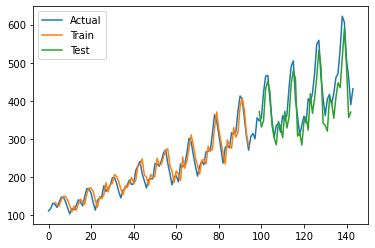

In [10]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Actual','Train','Test'])
plt.show()